In [275]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline
import time
import os
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import sys
sys.path.insert(0, '../mppi_numba')
from mppi_numba.density import Density, GaussianMixture
from mppi_numba.terrain import Terrain, TDM_Numba, TractionGrid
from mppi_numba.visualization import TDM_Visualizer, vis_density, vis_density_as_pmf
from mppi_numba.mppi import MPPI_Numba
from mppi_numba.config import Config

Grab the data used for training fells_nn

,t,px,py,pz,vx,vy,vz,cmd_v,w,cmd_w,...,elevation[15],elevation[16],elevation[17],elevation[18],elevation[19],elevation[20],elevation[21],elevation[22],elevation[23],elevation[24]
0,1.654526e+09,0.001312,-0.001258,0.002020,0.015726,0.005336,0.017344,0.0,-0.000503,0.0,...,-0.25,1.25,-0.25,-0.25,0.25,-0.25,-0.25,-0.25,-0.25,-0.25
1,1.654526e+09,0.001312,-0.001258,0.002020,0.015726,0.005336,0.017344,0.0,-0.000503,0.0,...,-0.25,1.25,-0.25,-0.25,0.25,-0.25,-0.25,-0.25,-0.25,-0.25
2,1.654526e+09,0.002112,-0.001433,0.001065,0.004828,-0.003153,-0.015522,0.0,0.000362,0.0,...,-0.25,1.25,-0.25,-0.25,0.25,-0.25,-0.25,-0.25,-0.25,-0.25
3,1.654526e+09,0.002112,-0.001433,0.001065,0.004828,-0.003153,-0.015522,0.0,0.000362,0.0,...,-0.25,1.25,-0.25,-0.25,0.25,-0.25,-0.25,-0.25,-0.25,-0.25
4,1.654526e+09,0.002112,-0.001433,0.001065,0.004828,-0.003153,-0.015522,0.0,0.000362,0.0,...,-0.25,1.25,-0.25,-0.25,0.25,-0.25,-0.25,-0.25,-0.25,-0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18925,1.654526e+09,-1.183982,-1.457209,0.011196,0.059229,-0.025754,0.015510,0.0,0.001306,0.0,...,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,1.25
18926,1.654526e+09,-1.185151,-1.455049,0.008881,0.019035,0.013827,-0.031514,0.0,0.001306,0.0,...,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,1.25
18927,1.654526e+09,-1.185151,-1.455049,0.008881,0.019035,0.013827,-0.031514,0.0,0.000059,0.0,...,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,1.25
18928,1.654526e+09,-1.185151,-1.455049,0.008881,0.019035,0.013827,-0.031514,0.0,0.000059,0.0,...,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,1.25


['t', 'px', 'py', 'pz', 'vx', 'vy', 'vz', 'cmd_v', 'w', 'cmd_w', 't_set', 'is_valid', 'rgb[0]', 'rgb[1]', 'rgb[2]', 'rgb[3]', 'rgb[4]', 'rgb[5]', 'rgb[6]', 'rgb[7]', 'rgb[8]', 'rgb[9]', 'rgb[10]', 'rgb[11]', 'rgb[12]', 'rgb[13]', 'rgb[14]', 'rgb[15]', 'rgb[16]', 'rgb[17]', 'rgb[18]', 'rgb[19]', 'rgb[20]', 'rgb[21]', 'rgb[22]', 'rgb[23]', 'rgb[24]', 'known[0]', 'known[1]', 'known[2]', 'known[3]', 'known[4]', 'known[5]', 'known[6]', 'known[7]', 'known[8]', 'known[9]', 'known[10]', 'known[11]', 'known[12]', 'known[13]', 'known[14]', 'known[15]', 'known[16]', 'known[17]', 'known[18]', 'known[19]', 'known[20]', 'known[21]', 'known[22]', 'known[23]', 'known[24]', 'ground[0]', 'ground[1]', 'ground[2]', 'ground[3]', 'ground[4]', 'ground[5]', 'ground[6]', 'ground[7]', 'ground[8]', 'ground[9]', 'ground[10]', 'ground[11]', 'ground[12]', 'ground[13]', 'ground[14]', 'ground[15]', 'ground[16]', 'ground[17]', 'ground[18]', 'ground[19]', 'ground[20]', 'ground[21]', 'ground[22]', 'ground[23]', 'ground[

/tmp/ipykernel_2741842/606513074.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_xy_speed'][df['cleaned_xy_speed']<0] = 0
/tmp/ipykernel_2741842/606513074.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_xy_speed'].iloc[:-vt_offset] = df['cleaned_xy_speed'].iloc[vt_offset:]
/tmp/ipykernel_2741842/606513074.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['v_ratio'][df['cleaned_cmd_v']==0] = 0 # n

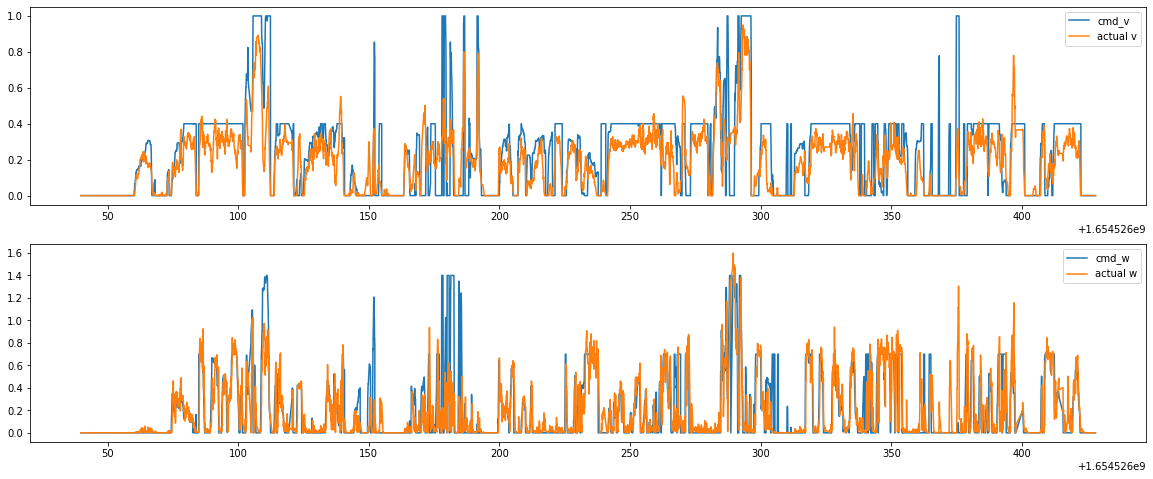

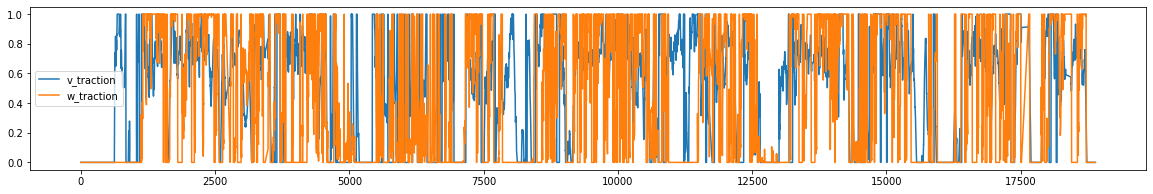

In [276]:
data_dir = "/home/jeremy/sara/phoenix-r1/src/mit_sara/mit_sara_experiments/data"
csv_file = "logs-2022-09-10-20-13-22.csv"
csv_path = os.path.join(data_dir, csv_file)

# Load copy of csv
df = pd.read_csv(csv_path)
# Filter out the invalid ones
df = df[(df["is_valid"]==1)&(df["t_set"]==1)]
display(df)
print(df.columns.to_list())

# What's a good offset for delay?
vt_offset = 40 # There's delay for v estimate since we apply filter on odom message and odom has delay
v_rolling_window = 40
istart = 0
iend = len(df)
vmag_offset = -0.15 # due to noise in odom estimates

df['cleaned_cmd_v'] = df['cmd_v'].abs()
df['cleaned_xy_speed'] = np.sqrt(df['vx']**2+df['vy']**2).rolling(v_rolling_window, min_periods=1).mean()+ vmag_offset
df['cleaned_xy_speed'][df['cleaned_xy_speed']<0] = 0
df['cleaned_xy_speed'].iloc[:-vt_offset] = df['cleaned_xy_speed'].iloc[vt_offset:]

df['cleaned_cmd_w'] = df['cmd_w'].abs()
df['cleaned_w']= df['w'].abs()

df = df.iloc[:-vt_offset]

fig, axes = plt.subplots(nrows=2, figsize=(20,8))
axes[0].plot(df['t'], df['cleaned_cmd_v'], label="cmd_v")
axes[0].plot(df['t'], df['cleaned_xy_speed'], label="actual v")
axes[0].legend()

axes[1].plot(df['t'], df['cleaned_cmd_w'], label="cmd_w")
axes[1].plot(df['t'], df['cleaned_w'], label="actual w")
axes[1].legend()

# Compute the v_ratio and w_ratio
df['v_ratio'] = df['cleaned_xy_speed']/(df['cleaned_cmd_v']+1e-3)
df['w_ratio'] = df['cleaned_w']/(df['cleaned_cmd_w']+1e-3)
df['v_ratio'] = np.clip(df['v_ratio'], 0, 1.0)
df['w_ratio'] = np.clip(df['w_ratio'], 0, 1.0)

df['v_ratio'][df['cleaned_cmd_v']==0] = 0 # np.nan
df['w_ratio'][df['cleaned_cmd_w']==0] = 0 # np.nan
df['v_error_weights'] = 1.0
df['w_error_weights'] = 1.0
df['v_error_weights'][df['cleaned_cmd_v']==0] = 0.0
df['w_error_weights'][df['cleaned_cmd_w']==0] = 0.0


fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(df['v_ratio'], label="v_traction")
ax.plot(df['w_ratio'], label="w_traction")
ax.legend()


log_df = df


,t,px,py,pz,vx,vy,vz,cmd_v,w,cmd_w,...,elevation[15],elevation[16],elevation[17],elevation[18],elevation[19],elevation[20],elevation[21],elevation[22],elevation[23],elevation[24]
0,1.654527e+09,-0.001140,-0.003279,-0.000070,-0.003476,-0.012002,-0.000384,0.0,-0.000747,0.0,...,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25
1,1.654527e+09,0.002470,-0.000448,-0.000030,0.045063,0.037505,0.002372,0.0,-0.000747,0.0,...,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25
2,1.654527e+09,0.002470,-0.000448,-0.000030,0.045063,0.037505,0.002372,0.0,-0.000747,0.0,...,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25
3,1.654527e+09,0.002470,-0.000448,-0.000030,0.045063,0.037505,0.002372,0.0,-0.001215,0.0,...,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25
4,1.654527e+09,0.001751,0.002961,-0.000512,-0.020365,0.031933,-0.003715,0.0,-0.001215,0.0,...,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6259,1.654527e+09,7.207040,3.108531,-0.167653,0.034399,0.035072,0.028136,0.0,-0.000869,0.0,...,0.75,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25
6260,1.654527e+09,7.207040,3.108531,-0.167653,0.034399,0.035072,0.028136,0.0,-0.000869,0.0,...,0.75,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25
6261,1.654527e+09,7.207040,3.108531,-0.167653,0.034399,0.035072,0.028136,0.0,-0.000869,0.0,...,0.75,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25
6262,1.654527e+09,7.200516,3.111999,-0.171012,-0.099530,-0.015769,-0.045830,0.0,-0.000734,0.0,...,0.75,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25


['t', 'px', 'py', 'pz', 'vx', 'vy', 'vz', 'cmd_v', 'w', 'cmd_w', 't_set', 'is_valid', 'rgb[0]', 'rgb[1]', 'rgb[2]', 'rgb[3]', 'rgb[4]', 'rgb[5]', 'rgb[6]', 'rgb[7]', 'rgb[8]', 'rgb[9]', 'rgb[10]', 'rgb[11]', 'rgb[12]', 'rgb[13]', 'rgb[14]', 'rgb[15]', 'rgb[16]', 'rgb[17]', 'rgb[18]', 'rgb[19]', 'rgb[20]', 'rgb[21]', 'rgb[22]', 'rgb[23]', 'rgb[24]', 'known[0]', 'known[1]', 'known[2]', 'known[3]', 'known[4]', 'known[5]', 'known[6]', 'known[7]', 'known[8]', 'known[9]', 'known[10]', 'known[11]', 'known[12]', 'known[13]', 'known[14]', 'known[15]', 'known[16]', 'known[17]', 'known[18]', 'known[19]', 'known[20]', 'known[21]', 'known[22]', 'known[23]', 'known[24]', 'ground[0]', 'ground[1]', 'ground[2]', 'ground[3]', 'ground[4]', 'ground[5]', 'ground[6]', 'ground[7]', 'ground[8]', 'ground[9]', 'ground[10]', 'ground[11]', 'ground[12]', 'ground[13]', 'ground[14]', 'ground[15]', 'ground[16]', 'ground[17]', 'ground[18]', 'ground[19]', 'ground[20]', 'ground[21]', 'ground[22]', 'ground[23]', 'ground[

/tmp/ipykernel_2741842/4157105994.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_xy_speed'][df['cleaned_xy_speed']<0] = 0
/tmp/ipykernel_2741842/4157105994.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_xy_speed'].iloc[:-vt_offset] = df['cleaned_xy_speed'].iloc[vt_offset:]
/tmp/ipykernel_2741842/4157105994.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['v_ratio'][df['cleaned_cmd_v']==0] = 0 

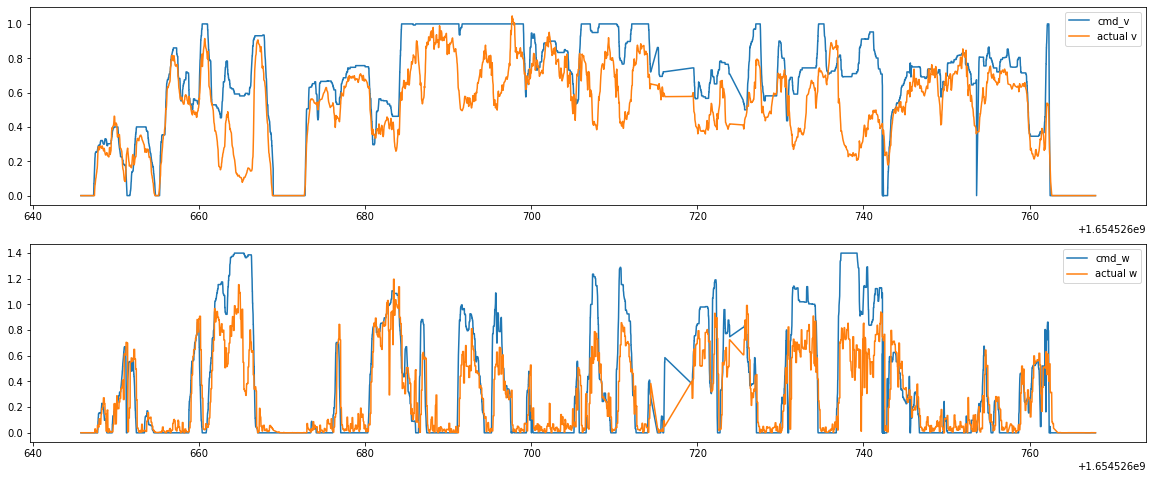

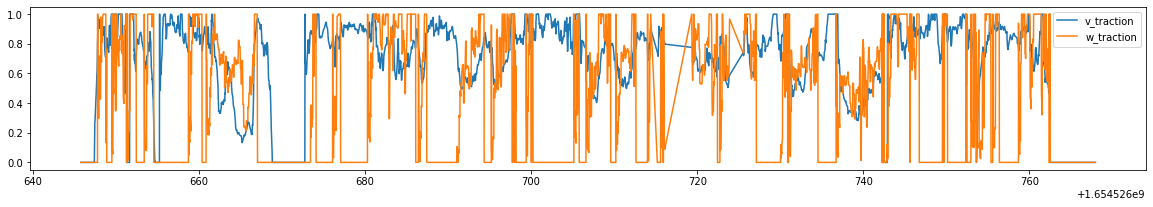

In [277]:
data_dir = "/home/jeremy/sara/phoenix-r1/src/mit_sara/mit_sara_experiments/data"
csv_file = "dirt_road-2022-09-10-20-16-40.csv"
csv_path = os.path.join(data_dir, csv_file)

# Load copy of csv
df = pd.read_csv(csv_path)
# Filter out the invalid ones
df = df[(df["is_valid"]==1)&(df["t_set"]==1)]
display(df)
print(df.columns.to_list())

# What's a good offset for delay?
vt_offset = 40 # There's delay for v estimate since we apply filter on odom message and odom has delay
v_rolling_window = 40
istart = 0
iend = len(df)
vmag_offset = -0.15 # due to noise in odom estimates

df['cleaned_cmd_v'] = df['cmd_v'].abs()
df['cleaned_xy_speed'] = np.sqrt(df['vx']**2+df['vy']**2).rolling(v_rolling_window, min_periods=1).mean()+ vmag_offset
df['cleaned_xy_speed'][df['cleaned_xy_speed']<0] = 0
df['cleaned_xy_speed'].iloc[:-vt_offset] = df['cleaned_xy_speed'].iloc[vt_offset:]

# display(df['cleaned_xy_speed'])

df['cleaned_cmd_w'] = df['cmd_w'].abs()
df['cleaned_w']= df['w'].abs()

# df = df.iloc[:-vt_offset]

fig, axes = plt.subplots(nrows=2, figsize=(20,8))
axes[0].plot(df['t'], df['cleaned_cmd_v'], label="cmd_v")
axes[0].plot(df['t'], df['cleaned_xy_speed'], label="actual v")
axes[0].legend()

axes[1].plot(df['t'], df['cleaned_cmd_w'], label="cmd_w")
axes[1].plot(df['t'], df['cleaned_w'], label="actual w")
axes[1].legend()

# Compute the v_ratio and w_ratio
df['v_ratio'] = df['cleaned_xy_speed']/(df['cleaned_cmd_v']+1e-3)
df['w_ratio'] = df['cleaned_w']/(df['cleaned_cmd_w']+1e-3)
df['v_ratio'] = np.clip(df['v_ratio'], 0, 1.0)
df['w_ratio'] = np.clip(df['w_ratio'], 0, 1.0)

df['v_ratio'][df['cleaned_cmd_v']==0] = 0 # np.nan
df['w_ratio'][df['cleaned_cmd_w']==0] = 0 # np.nan
df['v_error_weights'] = 1.0
df['w_error_weights'] = 1.0
df['v_error_weights'][df['cleaned_cmd_v']==0] = 0.0
df['w_error_weights'][df['cleaned_cmd_w']==0] = 0.0


fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(df['t'], df['v_ratio'], label="v_traction")
ax.plot(df['t'], df['w_ratio'], label="w_traction")
ax.legend()

In [278]:
dirt_df = df
fells_nn_df = pd.concat([log_df, dirt_df], axis=0)



### Visualze the training environment and trajectories

In [199]:
trained_folder = "tdm_models/ground_truth"
trained_model_subfolder = "fells_nn"
gt_folder = "tdm_models/ground_truth" # "tdm_models/ground_truth"
gt_model_subfolder = "fells_nn"
# -----------------------------------------------------------------

with open(os.path.join(trained_folder, trained_model_subfolder, "tdm_info.pickle" ), 'rb') as fh:
  pred_tdm_info = pickle.load(fh)
  print(pred_tdm_info.keys())

with open(os.path.join(gt_folder, gt_model_subfolder, "tdm_info.pickle"), 'rb') as fh:
  gt_tdm_info = pickle.load(fh)


id2rgb_map = gt_tdm_info['id2rgb_map']
rgb2id_map = gt_tdm_info['rgb2id_map']
id2rgb_map[-1] = (0,0,0)
rgb2id_map[(0,0,0)] = -1
id2rgb_map = {k: np.array(v)/255 for k, v in id2rgb_map.items()}
rgb2id_map = {np.array(v)/255: v for k, v in rgb2id_map.items()}
w = gt_tdm_info['width']
h = gt_tdm_info['height']

# TODO: only visualize partially based on known areas
semantic_grid = gt_tdm_info['color_indices'] 

# For places where we don't have access to ground truth, also mask away the same region in the predicted map.
gt_unknown = gt_tdm_info["unknown_colors_mask"]
pred_tdm_info["unknown_colors_mask"][gt_unknown] = 1
pred_tdm_info["unknown_colors_mask"][gt_unknown] = 1
# Adjust the PMF
pred_tdm_info["lin_pmf_grid"][0,gt_unknown] = 100
pred_tdm_info["lin_pmf_grid"][1:,gt_unknown] = 0
pred_tdm_info["ang_pmf_grid"][0,gt_unknown] = 100
pred_tdm_info["ang_pmf_grid"][1:,gt_unknown] = 0
# For places where ground truth is 0 traction, we mask away the predicted map as well
gt_no_traction_mask = gt_tdm_info["lin_pmf_grid"][0,:,:]==100
pred_tdm_info["lin_pmf_grid"][0,gt_no_traction_mask]=100
pred_tdm_info["lin_pmf_grid"][1:,gt_no_traction_mask]=0
pred_tdm_info["ang_pmf_grid"][0,gt_no_traction_mask]=100
pred_tdm_info["ang_pmf_grid"][1:,gt_no_traction_mask]=0

dict_keys(['xlimits', 'ylimits', 'res', 'bin_values', 'bin_values_bounds', 'height', 'width', 'lin_pmf_grid', 'ang_pmf_grid', 'normalized_confidence', 'color_indices', 'color_mask', 'unknown_colors_mask', 'elevation', 'id2rgb_map', 'rgb2id_map'])


In [212]:
# Can generate the TDM object
# Can generate the TDM object

def reset_tdm_from_info(lin_tdm, ang_tdm, tdm_info, alpha_dyn, obstacle_map=None, unknown_map=None):

  tdm_params = {
    "xlimits": tdm_info['xlimits'],
    "ylimits": tdm_info['ylimits'],
    "res": tdm_info['res'],
    "bin_values": tdm_info['bin_values'],
    "bin_values_bounds": tdm_info['bin_values_bounds'],
    "det_dynamics_cvar_alpha": alpha_dyn,
  }
  
  lin_tdm.reset()
  ang_tdm.reset()
  lin_tdm.set_TDM_from_PMF_grid(tdm_info['lin_pmf_grid'], tdm_params, obstacle_map=obstacle_map, unknown_map=unknown_map)
  ang_tdm.set_TDM_from_PMF_grid(tdm_info['ang_pmf_grid'], tdm_params, obstacle_map=obstacle_map, unknown_map=unknown_map)

max_speed = 3.0
use_tdm = True # True # True
use_det_dynamics = False # True
use_nom_dynamics_with_speed_map = False # 
use_costmap = False

# ------ General configs for both MPPI and TDM ------
cfg_kwargs = dict(
  T = 10.0,
  dt = 0.1,
  num_grid_samples =  1024, # 5*1024, #1024,
  num_control_rollouts = 1024,
  max_speed_padding = 0, #max_speed+2.0,
  num_vis_state_rollouts = 100,
  max_map_dim =(140, 85),
  seed = 1,
  use_tdm = use_tdm,
  use_det_dynamics = use_det_dynamics,
  use_nom_dynamics_with_speed_map = use_nom_dynamics_with_speed_map,
  use_costmap = use_costmap,
)
cfg = Config(**cfg_kwargs)


x0=np.array([12.0, 15.0, 0])
xgoal= np.array([20, -5])
goal_tolerance = 2.0
mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0,
    xgoal=xgoal,

    # For risk-aware min time planning
    goal_tolerance=goal_tolerance,
    v_post_rollout=0.01,
    cvar_alpha=1.0, # use the mean of objectives if cvar_alpha=1.0
    alpha_dyn=1.0, # sample tractions from worst alpha_dyn-percentile  (mostly for TDM)

    dist_weight=1.0,

    # Hyper parameters
    lambda_weight=1.0,
    num_opt=1, # how many steps in each solve() function call

    # Control and sample specification
    u_std=np.array([2.0, 2.0]), # angular part affects how much robot turns to squeeze through gaps
    vrange = np.array([0.0, max_speed]), 
    wrange=np.array([-np.pi, np.pi]),
)

gt_lin_tdm = TDM_Numba(cfg)
gt_ang_tdm = TDM_Numba(cfg)
pred_lin_tdm = TDM_Numba(cfg)
pred_ang_tdm = TDM_Numba(cfg)
mppi_planner = MPPI_Numba(cfg)
reset_tdm_from_info(gt_lin_tdm, gt_ang_tdm, gt_tdm_info, mppi_params['alpha_dyn'])
reset_tdm_from_info(pred_lin_tdm, pred_ang_tdm, pred_tdm_info, mppi_params['alpha_dyn'])

lin_tdm_vis = TDM_Visualizer(gt_lin_tdm, tdm_contains_semantic_grid=False)
ang_tdm_vis = TDM_Visualizer(gt_ang_tdm, tdm_contains_semantic_grid=False)




TDM has initialized GPU memory after 0.04994392395019531 s
TDM has initialized GPU memory after 0.04077959060668945 s
TDM has initialized GPU memory after 0.04051494598388672 s
TDM has initialized GPU memory after 0.040599822998046875 s
MPPI planner has initialized GPU memory after 0.016277074813842773 s


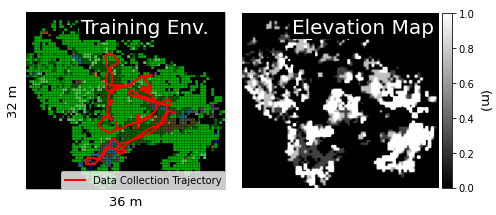

In [330]:
xrange = int(gt_tdm_info["xlimits"][1]-gt_tdm_info["xlimits"][0])
yrange = int(gt_tdm_info["ylimits"][1]-gt_tdm_info["ylimits"][0])


fig, axes = plt.subplots(ncols=2, figsize=(7, 4))

# Visualize the semantics
ax = axes[0]
lin_tdm_vis.draw(ax=ax, semantic_grid=semantic_grid, id2rgb_map=id2rgb_map)
ax.set_xlabel("{} m".format(xrange),fontsize=13, labelpad=-3)
ax.set_ylabel("{} m".format(yrange),fontsize=13, labelpad=-3)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.axis("on")
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

# Overlay the training trajectory
pixel_loc_x = (dirt_df['px']-gt_tdm_info["xlimits"][0])-18
pixel_loc_y = -(dirt_df['py']-gt_tdm_info["ylimits"][0])+17
ax.plot(pixel_loc_x, pixel_loc_y, 'r-', linewidth=2)

pixel_loc_x = (log_df['px']-gt_tdm_info["xlimits"][0])-21
pixel_loc_y = (log_df['py']-gt_tdm_info["ylimits"][0])-1
ax.plot(pixel_loc_x, pixel_loc_y, 'r-', linewidth=2, label="Data Collection Trajectory")
ax.legend(loc="lower right")

ax.text(-9, 19.5, "Training Env.", 
  bbox={'facecolor':'k','alpha':1.0,'edgecolor':'none','pad':2},
  ha='left', va='center', fontsize=20, color="white")


# Visualize the height map
# lin = traction_grid.lin_traction
ax = axes[1]
img = ax.imshow(gt_tdm_info['elevation'], origin='lower', vmin=0, vmax=1.0, cmap='gray')
# ax.set_title('elevation')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('(m)', rotation=270, fontsize=13)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.axis("off")
ax.text(18, 59, "Elevation Map", 
  bbox={'facecolor':'k','alpha':1.0,'edgecolor':'none','pad':2},
  ha='left', va='center', fontsize=20, color="white")


plt.tight_layout()
# plt.show()
plt.savefig('plots/bag_based_exp/train_env_semantic_and_elevation.png', dpi=300, facecolor="w")


0       19.997484
1       19.997484
2       19.997134
3       19.997134
4       19.997134
          ...    
6259    26.217062
6260    26.217062
6261    26.217062
6262    26.223998
6263    26.223998
Name: py, Length: 24360, dtype: float64

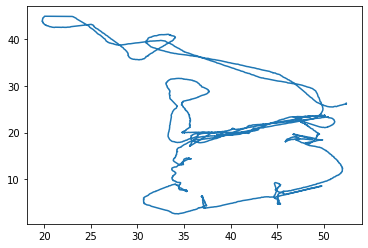

In [239]:
fig, ax = plt.subplots()
ax.plot(pixel_loc_x, pixel_loc_y)

### Visualize the test environment and GMM-based confidence score

In [23]:
# Without dirt along edge (40% grass) (keep, det success rate better than proposed, dt+dist cost)
# logfile = "confidence_score_benchmark/fells_nn_predicts_wp_forest2_trial_20_num_thres_5_data_20220914-0107.pickle"
logfile = "confidence_score_benchmark/fells_nn_predicts_wp_forest2_trial_10_num_thres_5_data_20220914-0140.pickle"

# -----------------------------------------------------------------

with open(logfile, 'rb') as fh:
  exp_log = pickle.load(fh)

for k, v in exp_log.items():
  if k not in ["logger"]:
  # if k not in ["logger"]:
    print("{}: {}".format(k, v))

logger = exp_log['logger']
start_goal_pairs = exp_log['start_goal_pairs']
cfg=exp_log['cfg'] 
max_speed=exp_log['max_speed'] 
max_steps=exp_log['max_steps'] 
confidence_thres_list=exp_log['confidence_thres_list']
confidence_thres_list_sorted = sorted(confidence_thres_list)

start_goal_pairs: [(array([ 5, -2,  0]), array([ 12, -15])), (array([ 8, 17,  0]), array([20, -5])), (array([25, 30,  0]), array([ 20, -10]))]
cfg: <mppi_numba.config.Config object at 0x7f6f7571ec40>
max_speed: 3
max_steps: 300
confidence_thres_list: [0.0, 0.2, 0.4, 0.6, 0.8]


Plot the test scenario and the test pairs

In [24]:
trained_folder = "tdm_models/predicted"
trained_model_subfolder = "fells_nn_predicts_wp_forest1"
gt_folder = "tdm_models/ground_truth" # "tdm_models/ground_truth"
gt_model_subfolder = "wp_forest1"
# -----------------------------------------------------------------


with open(os.path.join(trained_folder, trained_model_subfolder, "tdm_info.pickle" ), 'rb') as fh:
  pred_tdm_info = pickle.load(fh)
  print(pred_tdm_info.keys())

with open(os.path.join(gt_folder, gt_model_subfolder, "tdm_info.pickle"), 'rb') as fh:
  gt_tdm_info = pickle.load(fh)


id2rgb_map = gt_tdm_info['id2rgb_map']
rgb2id_map = gt_tdm_info['rgb2id_map']
id2rgb_map[-1] = (0,0,0)
rgb2id_map[(0,0,0)] = -1
id2rgb_map = {k: np.array(v)/255 for k, v in id2rgb_map.items()}
rgb2id_map = {np.array(v)/255: v for k, v in rgb2id_map.items()}
w = gt_tdm_info['width']
h = gt_tdm_info['height']

# TODO: only visualize partially based on known areas
semantic_grid = gt_tdm_info['color_indices'] 


dict_keys(['xlimits', 'ylimits', 'res', 'bin_values', 'bin_values_bounds', 'height', 'width', 'lin_pmf_grid', 'ang_pmf_grid', 'normalized_confidence', 'color_indices', 'color_mask', 'unknown_colors_mask', 'elevation', 'id2rgb_map', 'rgb2id_map'])


In [97]:
# Can generate the TDM object

def reset_tdm_from_info(lin_tdm, ang_tdm, tdm_info, alpha_dyn, obstacle_map=None, unknown_map=None):

  tdm_params = {
    "xlimits": tdm_info['xlimits'],
    "ylimits": tdm_info['ylimits'],
    "res": tdm_info['res'],
    "bin_values": tdm_info['bin_values'],
    "bin_values_bounds": tdm_info['bin_values_bounds'],
    "det_dynamics_cvar_alpha": alpha_dyn,
  }
  
  lin_tdm.reset()
  ang_tdm.reset()
  lin_tdm.set_TDM_from_PMF_grid(tdm_info['lin_pmf_grid'], tdm_params, obstacle_map=obstacle_map, unknown_map=unknown_map)
  ang_tdm.set_TDM_from_PMF_grid(tdm_info['ang_pmf_grid'], tdm_params, obstacle_map=obstacle_map, unknown_map=unknown_map)


max_speed = 3.0
use_tdm = True # True # True
use_det_dynamics = False # True
use_nom_dynamics_with_speed_map = False # 
use_costmap = False

# ------ General configs for both MPPI and TDM ------
cfg_kwargs = dict(
  T = 10.0,
  dt = 0.1,
  num_grid_samples =  1024, # 5*1024, #1024,
  num_control_rollouts = 1024,
  max_speed_padding = 0, #max_speed+2.0,
  num_vis_state_rollouts = 100,
  max_map_dim =(140, 85),
  seed = 1,
  use_tdm = use_tdm,
  use_det_dynamics = use_det_dynamics,
  use_nom_dynamics_with_speed_map = use_nom_dynamics_with_speed_map,
  use_costmap = use_costmap,
)
cfg = Config(**cfg_kwargs)


x0=np.array([12.0, 15.0, 0])
xgoal= np.array([20, -5])
goal_tolerance = 2.0
mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0,
    xgoal=xgoal,

    # For risk-aware min time planning
    goal_tolerance=goal_tolerance,
    v_post_rollout=0.01,
    cvar_alpha=1.0, # use the mean of objectives if cvar_alpha=1.0
    alpha_dyn=1.0, # sample tractions from worst alpha_dyn-percentile  (mostly for TDM)

    dist_weight=1.0,

    # Hyper parameters
    lambda_weight=1.0,
    num_opt=1, # how many steps in each solve() function call

    # Control and sample specification
    u_std=np.array([2.0, 2.0]), # angular part affects how much robot turns to squeeze through gaps
    vrange = np.array([0.0, max_speed]), 
    wrange=np.array([-np.pi, np.pi]),
)

gt_lin_tdm = TDM_Numba(cfg)
gt_ang_tdm = TDM_Numba(cfg)
pred_lin_tdm = TDM_Numba(cfg)
pred_ang_tdm = TDM_Numba(cfg)
mppi_planner = MPPI_Numba(cfg)
reset_tdm_from_info(gt_lin_tdm, gt_ang_tdm, gt_tdm_info, mppi_params['alpha_dyn'])
reset_tdm_from_info(pred_lin_tdm, pred_ang_tdm, pred_tdm_info, mppi_params['alpha_dyn'])


TDM has initialized GPU memory after 0.0417635440826416 s
TDM has initialized GPU memory after 0.04055309295654297 s
TDM has initialized GPU memory after 0.04155302047729492 s
TDM has initialized GPU memory after 0.04013228416442871 s
MPPI planner has initialized GPU memory after 0.016313552856445312 s


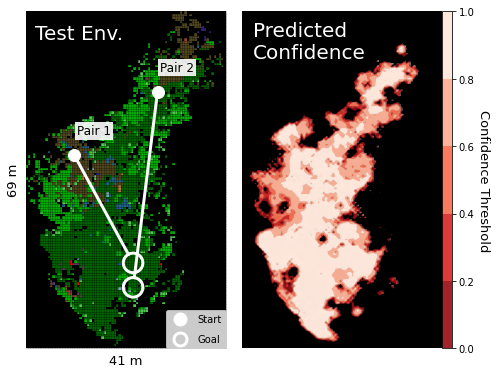

In [191]:
fix, axes = plt.subplots(ncols=2, figsize=(7, 7))
# First, showing the test pairs
ax = axes[0]
lin_tdm_vis = TDM_Visualizer(gt_lin_tdm, tdm_contains_semantic_grid=False)
lin_tdm_vis.draw(semantic_grid=semantic_grid, id2rgb_map=id2rgb_map, ax=ax)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
for pair_i, (x0, xgoal) in enumerate(start_goal_pairs):
  if pair_i==0:
    continue
  ax.plot([x0[0]], [x0[1]], 'wo', markersize=12)
  v = np.array([xgoal[0]-x0[0], xgoal[1]-x0[1]])
  vstart = np.array([x0[0], x0[1]])
  goal_tolerance = mppi_params['goal_tolerance']
  vend = vstart + v* (np.linalg.norm(v)-goal_tolerance)/np.linalg.norm(v)
  ax.plot([vstart[0], vend[0]],[vstart[1], vend[1]] , 'w-', linewidth=3)
  c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='w', fill=False, linewidth=3, zorder=6)
  ax.add_patch(c1)

  # Add text to each of the starting point to mark Test Pairs
  ax.text(vstart[0]+4, vstart[1]+5, "Pair {}".format(pair_i), 
    bbox={'facecolor':'white','alpha':0.9,'edgecolor':'none','pad':2},
    ha='center', va='center', fontsize=12, color="black")

ax.text(0, 42, "Test Env.", 
  bbox={'facecolor':'k','alpha':1.0,'edgecolor':'none','pad':2},
  ha='left', va='center', fontsize=20, color="white")

# Dummy objects for labels
ax.plot([],[], "wo", markersize=13, label="Start")
ax.plot([],[],'wo', markerfacecolor="none", markersize=13, markeredgewidth=3, label="Goal")
ax.set_xlabel("41 m",fontsize=13, labelpad=-3)
ax.set_ylabel("69 m",fontsize=13, labelpad=-3)
ax.axis("on")
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.legend(labelspacing=1, loc="lower right", fontsize=10)

# Secondly, show the GMM model and how the level set changes with the selected values
ax = axes[1]
img = ax.imshow(pred_tdm_info['normalized_confidence'], 
  origin='lower', vmin=0, vmax=1.0, cmap='gray', alpha=1.0)
ctr = ax.contourf(pred_tdm_info['normalized_confidence'],
                 levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                 cmap="Reds_r",
                alpha=0.9, antialiased=True)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.0)
# ax.axis("off")
# ax.set_title("hi", )
cbar = plt.colorbar(ctr, cax=cax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Confidence Threshold', rotation=270, fontsize=13)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.axis("off")
ax.text(4, 125, "Predicted\nConfidence", 
  bbox={'facecolor':'k','alpha':0.0,'edgecolor':'none','pad':2},
  ha='left', va='center', fontsize=20, color="white")
plt.tight_layout()
# plt.savefig('plots/bag_based_exp/test_env_and_confidence.png', dpi=300, facecolor="w")



Plot the success rate and time to goal

/tmp/ipykernel_2741842/1290631269.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l_nn, l_gt], labels=["NN From Training Env.", "NN Trained with Test Data"],


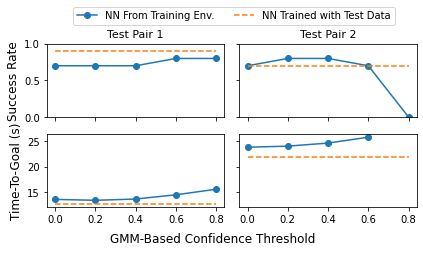

In [325]:

num_pairs = len(start_goal_pairs)
fig, axes_2d = plt.subplots(ncols=2, nrows=2, sharex="col", sharey="row",
                          figsize=(6,3))

axes_row0 = axes_2d[0]

for pair_i in range(num_pairs):
  if pair_i==0:
    continue
  
  ax = axes_row0[pair_i-1]
  pari_i_logger = logger[logger['start_goal_i']==pair_i]

  # Success rate
  predictor_mask = ~pari_i_logger["use_gt"]
  success_rate = []
  for thres in confidence_thres_list_sorted:
    sub_logger = pari_i_logger[(pari_i_logger["confidence_thres"]==thres)&predictor_mask]
    success_rate.append(sub_logger['success'].mean())
  # Plot the gt planner
  ax.plot(confidence_thres_list_sorted, success_rate, '-o', label="NN Trained in Env. A")

  sub_logger = pari_i_logger[pari_i_logger['use_gt']]
  ax.plot(confidence_thres_list_sorted, [sub_logger['success'].mean()]*len(confidence_thres_list_sorted),
    '--', label="NN Trained on Test Data")
  ax.set_ylim([0,1])
  if pair_i==1:
    ax.set_ylabel("Success Rate", fontsize=12)
  
  ax.set_title("Test Pair {}".format(pair_i), fontsize=11)
  # ax.legend()
  
  # ax.axes.yaxis.set_ticks([])

axes_row1 = axes_2d[1]
# # Plot the time-to-goal
for pair_i in range(num_pairs):
  if pair_i==0:
    continue
  ax = axes_row1[pair_i-1]
  pari_i_logger = logger[logger['start_goal_i']==pair_i]
  predictor_mask = ~pari_i_logger["use_gt"]
  time_to_goal = []
  for thres in confidence_thres_list_sorted:
    sub_logger = pari_i_logger[(pari_i_logger["confidence_thres"]==thres)&predictor_mask]
    time_to_goal.append(sub_logger['time_to_goal'].mean())

  l_nn = ax.plot(confidence_thres_list_sorted, time_to_goal, '-o', label="NN Trained in Env. A")
  sub_logger = pari_i_logger[pari_i_logger['use_gt']]
  l_gt = ax.plot(confidence_thres_list_sorted, [sub_logger['time_to_goal'].mean()]*len(confidence_thres_list_sorted),
    '--', label="NN Trained on Test Env. B")
  # ax.legend()
  if pair_i == 1:
    ax.set_ylabel("Time-To-Goal (s)", fontsize=12)

fig.legend([l_nn, l_gt], labels=["NN From Training Env.", "NN Trained with Test Data"],
        loc="upper center", ncol=2, fontsize=10,
        bbox_to_anchor=(0.55, 1.08))
fig.text(0.5, -0.02, r'GMM-Based Confidence Threshold', fontsize=12,
              ha='center', va='center')
# plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
# plt.savefig('plots/bag_based_exp/test_env_success_rate_time_to_goals.png', dpi=300, facecolor="w", bbox_inches='tight')